## Plant Disease CLassification - PyTorch 

Task 2

Marium Waseem and Kovarthanan Kesavan 

Dataset : https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset

Github: https://github.com/MariumWaseem1/INM702.git

In [1]:
"""
Importing needed libraries
"""
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import Counter
import itertools

In [6]:
""" 
 Dataset path
"""
training_image_path = 'plant disease dataset/Train/Train'
validation_image_path = 'plant disease dataset/Validation/Validation'
testing_image_path = 'plant disease dataset/Test/Test'

In [7]:
""" 
Let's define the transformatiions that needed to be applied on the images. 
"""
image_transformation = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor()  # Converting as tensor
])

In [8]:
""" 
Definig the dataset by applying transfromations on the datsset images.
"""
training_dataset = datasets.ImageFolder(
    training_image_path, transform=image_transformation)
validation_dataset = datasets.ImageFolder(
    validation_image_path, transform=image_transformation)
testing_dataset = datasets.ImageFolder(
    testing_image_path, transform=image_transformation)

In [9]:
"""  
Insights of defined dataset. 
"""

print("Size of Training Data : ", len(training_dataset))
print("Size of Validation Data : ", len(validation_dataset))
print("Size of Testing Data : ", len(testing_dataset))
print("Unique Classes : ", training_dataset.classes)

Size of Training Data :  1322
Size of Validation Data :  60
Size of Testing Data :  150
Unique Classes :  ['Healthy', 'Powdery', 'Rust']


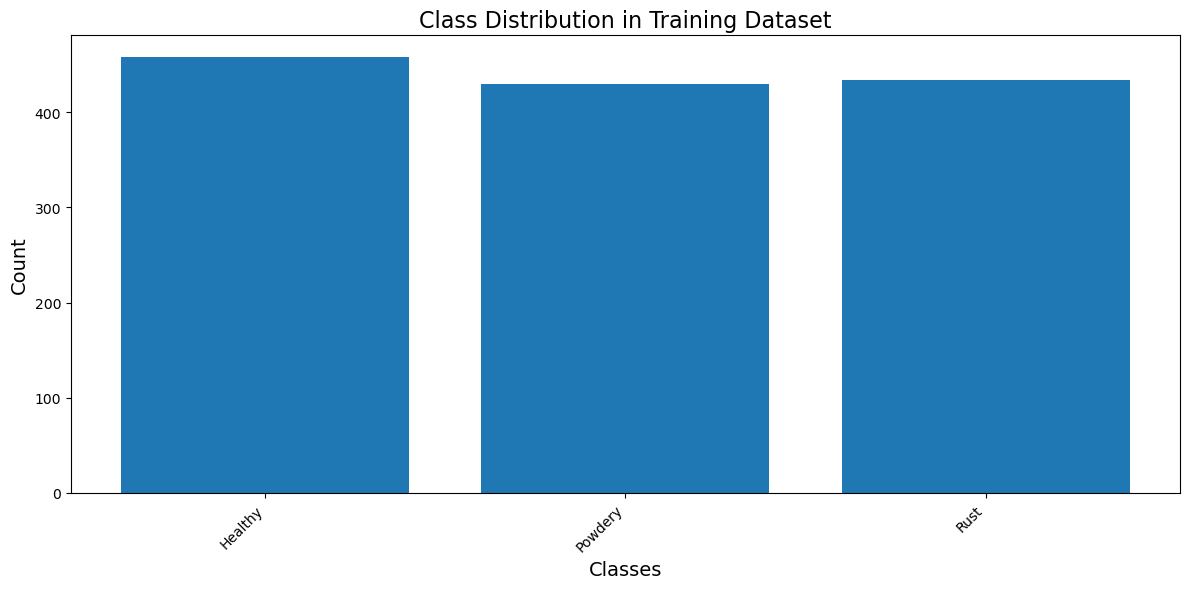

In [13]:
""" 
Visualizing the classes frequency 
"""
# Extracting class counts from the training dataset
class_counts = Counter(training_dataset.targets)
class_names = training_dataset.classes

# Prepare data for plotting
class_labels = [class_names[i] for i in class_counts.keys()]
class_values = list(class_counts.values())

# Plotting the class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_labels, class_values)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution in Training Dataset", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./plots/class_distribution.png')
plt.show()

## Base CNN model for plant disease prediction

In [15]:
""" 
Defining the dataloaders. 
    - batch_size : 32
"""
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)
testing_loader = DataLoader(testing_dataset, batch_size=32)

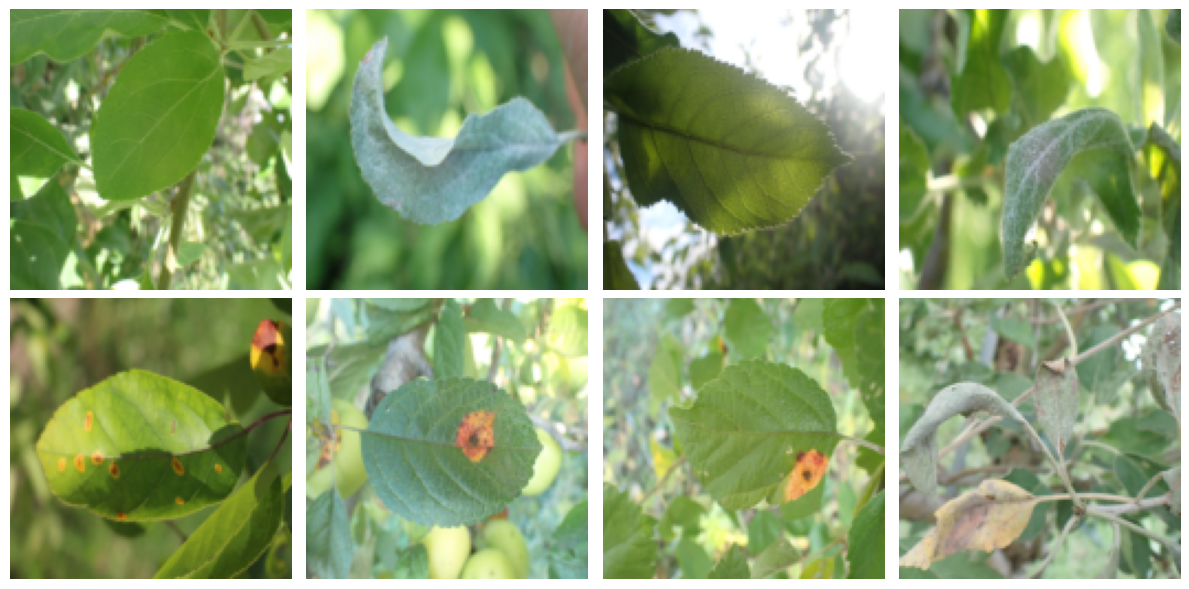

In [16]:
""" 
View the images from the dataset. 
"""


def view_images(data_loader, num_images=8):
    # Extracting images from the data loader
    images, _ = next(iter(data_loader))

    # Defining the count
    images = images[:num_images]

    # Visualize images
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        image = images[i].permute(1, 2, 0)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Visualize images from the training dataset
view_images(training_loader)

In [21]:
""" 
Defining the basic CNN model to find how well it can predict plant disease. 
"""


class Base_CNN(nn.Module):
    def __init__(self):
        super(Base_CNN, self).__init__()
        # Definig 1 covolutional layer
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pooling = nn.MaxPool2d(2, 2)

        # Two fully connected layers
        self.fully_connected_1 = nn.Linear(64 * 32 * 32, 128)
        self.fully_connected_2 = nn.Linear(128, 3)  # 3 classes

    def forward(self, x):
        x = self.pooling(torch.relu(self.conv1(x)))
        x = self.pooling(torch.relu(self.conv2(x)))  # Second conv + pooling
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fully_connected_1(x))
        x = self.fully_connected_2(x)
        return x

In [22]:
""" 
Initializing the Basic CNN model with, 
    - Loss : CrossEntropyLoss
    - Optimizer : SGD
    - Learning Rate : 0.01
"Defining the dataloaders. 
    - batch_size : 32
"""
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)
testing_loader = DataLoader(testing_dataset, batch_size=32)

In [23]:
base_model = Base_CNN()


In [24]:
optimizer_base_CNN = torch.optim.SGD(base_model.parameters(), lr=0.01)

In [26]:
criterion_base_CNN = nn.CrossEntropyLoss()


In [27]:
"""
Training the Base CNN model.
"""
# Flags to store values for visualization
training_losses = []
training_accuracies = []
validation_accuracies = []

print("Starting training...")
epochs_count = 10

for epoch in range(epochs_count):
    base_model.train()
    epoch_loss = 0.0
    training_correct = 0
    training_total = 0

    for inputs, labels in training_loader:
        optimizer_base_CNN.zero_grad()
        batch_outputs = base_model(inputs)
        batch_loss = criterion_base_CNN(batch_outputs, labels)
        batch_loss.backward()
        optimizer_base_CNN.step()

        epoch_loss += batch_loss.item()
        _, predicted = batch_outputs.max(1)
        training_total += labels.size(0)
        training_correct += predicted.eq(labels).sum().item()

    training_accuracy = 100. * training_correct / training_total
    training_losses.append(epoch_loss/len(training_loader))
    training_accuracies.append(training_accuracy)

    """ 
    Validation 
    """
    base_model.eval()
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = base_model(inputs)
            _, predicted = outputs.max(1)
            validation_total += labels.size(0)
            validation_correct += predicted.eq(labels).sum().item()

    validation_accuray = 100. * validation_correct / validation_total
    validation_accuracies.append(validation_accuray)

    print(f'Completed Base_CNN Epoch : {epoch+1}/{epochs_count} :')
    print(f'Training Loss: {epoch_loss/len(training_loader):.3f}')
    print(f'Training Accuracy: {training_accuracy:.2f}%')
    print(f'Validation Accuracy: {validation_accuray:.2f}%\n')

Starting training...
Completed Base_CNN Epoch : 1/10 :
Training Loss: 1.091
Training Accuracy: 37.75%
Validation Accuracy: 48.33%

Completed Base_CNN Epoch : 2/10 :
Training Loss: 1.049
Training Accuracy: 48.34%
Validation Accuracy: 33.33%

Completed Base_CNN Epoch : 3/10 :
Training Loss: 0.973
Training Accuracy: 57.19%
Validation Accuracy: 33.33%

Completed Base_CNN Epoch : 4/10 :
Training Loss: 0.900
Training Accuracy: 56.28%
Validation Accuracy: 35.00%

Completed Base_CNN Epoch : 5/10 :
Training Loss: 0.808
Training Accuracy: 61.80%
Validation Accuracy: 48.33%

Completed Base_CNN Epoch : 6/10 :
Training Loss: 0.763
Training Accuracy: 66.41%
Validation Accuracy: 51.67%

Completed Base_CNN Epoch : 7/10 :
Training Loss: 0.685
Training Accuracy: 68.46%
Validation Accuracy: 55.00%

Completed Base_CNN Epoch : 8/10 :
Training Loss: 0.669
Training Accuracy: 71.48%
Validation Accuracy: 46.67%

Completed Base_CNN Epoch : 9/10 :
Training Loss: 0.662
Training Accuracy: 70.57%
Validation Accurac

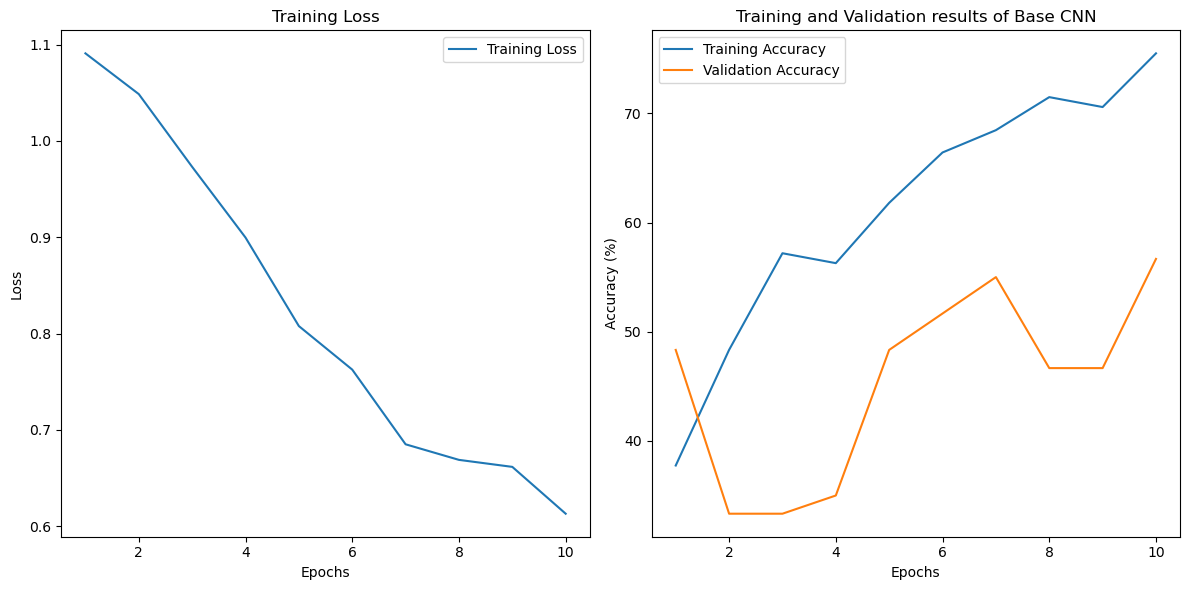

In [28]:
""" 
Visiualizing training and validation results of the Base model.
"""
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_count + 1), training_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_count + 1),
         training_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs_count + 1), validation_accuracies,
         label='Validation Accuracy')
plt.title('Training and Validation results of Base CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('./plots/base_cnn_training_results.png')
plt.show()

In [29]:
""" 
Evaluating the base CNN model 
"""
base_model.eval()
testing_correct = 0
testing_total = 0
with torch.no_grad():
    for inputs, labels in testing_loader:
        outputs = base_model(inputs)
        _, predicted = outputs.max(1)
        testing_total += labels.size(0)
        testing_correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * testing_correct / testing_total
print(f'Test Accuracy for Base CNN: {100.*testing_correct/testing_total:.2f}%')

Test Accuracy for Base CNN: 56.00%


## Implement Improvement 1

- Larger input size (224x224) for better feature detection
- Data augmentation with random flips for better generalization
- ImageNet normalization for training stability

In [39]:
image_transform_improved = transforms.Compose([
    transforms.Resize((224, 224)),          
    transforms.RandomHorizontalFlip(),      
    transforms.ToTensor(),      
             
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225]) 
])


In [40]:
# Updated datasets with new transform
training_dataset_improved = datasets.ImageFolder(
    training_image_path, transform=image_transform_improved)
validation_dataset_improved = datasets.ImageFolder(
    validation_image_path, transform=image_transform_improved)
testing_dataset_improved = datasets.ImageFolder(
    testing_image_path, transform=image_transform_improved)

In [41]:
training_loader_improved = DataLoader(
    training_dataset_improved, batch_size=32, shuffle=True)
validation_loader_improved = DataLoader(
    validation_dataset_improved, batch_size=32)
testing_loader_improved = DataLoader(testing_dataset_improved, batch_size=32)

## Implement Improvement 2

- Three convolutional layers instead of one
- Added padding to maintain spatial dimensions
- Increased number of filters (32, 64, 128)
-drop out


In [42]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        
        # convolution layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # pooling and fully connected layers
        self.pooling = nn.MaxPool2d(2, 2)
        self.fully_connected_1 = nn.Linear(128 * 28 * 28, 512)
        self.fully_connected_2 = nn.Linear(512, num_classes)
        
        # dropout - overfitting fix
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        
        x = self.pooling(torch.relu(self.conv1(x)))
        x = self.pooling(torch.relu(self.conv2(x)))
        x = self.pooling(torch.relu(self.conv3(x)))
        
        
        x = x.view(-1, 128 * 28 * 28)
        
        
        x = torch.relu(self.fully_connected_1(x))
        x = self.dropout(x)
        x = self.fully_connected_2(x)
        
        return x


In [43]:
""" 
initializing the improved cnn modell 
"""
num_classes = len(training_dataset_improved.classes)
improved_model = ImprovedCNN(num_classes)

#### Implement Improvement 3

- Using Adam optimizer instead of SGD
- Added dropout for regularization



In [44]:
# Training components
improved_criterion = nn.CrossEntropyLoss()
improved_optimizer = torch.optim.Adam(
    improved_model.parameters(), lr=0.01)  # Changed to Adam

In [45]:
# Flags to store values for visualization
training_losses = []
training_accuracies = []
validation_accuracies = []
epochs_count = 10
best_val_acc = 0

Model Architecture:
ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fully_connected_1): Linear(in_features=100352, out_features=512, bias=True)
  (fully_connected_2): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Input image shape: torch.Size([32, 3, 224, 224])

Starting training with Adam optimizer and learning rate 0.01...
Training batch shape: torch.Size([32, 3, 224, 224])
Epoch [1/10]:
Training Loss: 12.216
Training Accuracy: 44.55%
Validation Accuracy: 63.33%
--------------------------------------------------
Epoch [2/10]:
Training Loss: 0.944
Training Accuracy: 53.03%
Validation Accuracy: 61.67%
--------------------------------------------------
Epo

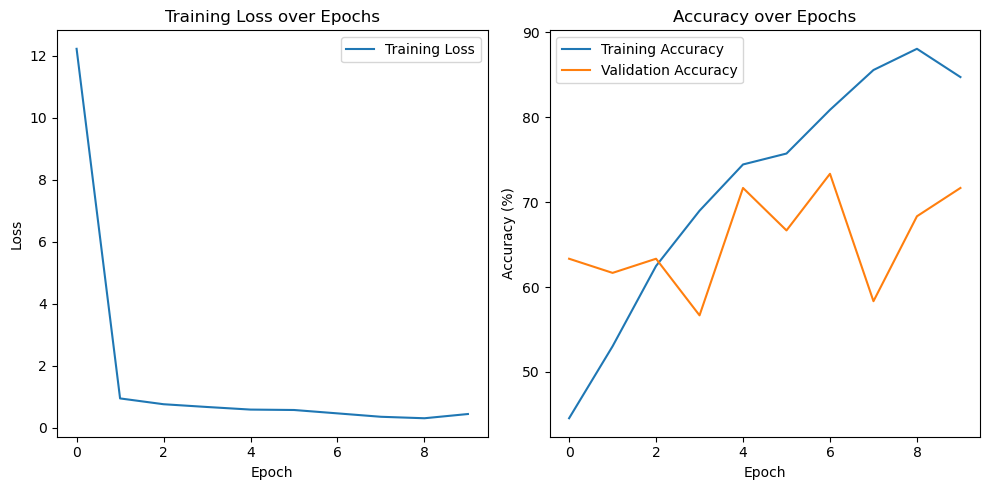

In [47]:
# Verify model structure first
print("Model Architecture:")
print(improved_model)

# Initialize tracking variables
training_losses = []
training_accuracies = []
validation_accuracies = []
epochs_count = 10
best_val_acc = 0

# Print data shape verification
for images, _ in training_loader_improved:
   print("Input image shape:", images.shape)  
   break

print("\nStarting training with Adam optimizer and learning rate 0.01...")

for epoch in range(epochs_count):
   # Training Phase
   improved_model.train()
   training_loss = 0.0
   training_correct = 0
   training_total = 0

   for inputs, labels in training_loader_improved:
       # Verify input shapes during first epoch
       if epoch == 0 and training_total == 0:
           print(f"Training batch shape: {inputs.shape}")
       
       improved_optimizer.zero_grad()
       outputs = improved_model(inputs)
       loss = improved_criterion(outputs, labels)
       loss.backward()
       improved_optimizer.step()
       
       training_loss += loss.item()
       _, predicted = torch.max(outputs, 1)
       training_correct += (predicted == labels).sum().item()
       training_total += labels.size(0)

   epoch_loss = training_loss / len(training_loader_improved)
   epoch_accuracy = (training_correct / training_total) * 100

   training_losses.append(epoch_loss)
   training_accuracies.append(epoch_accuracy)

   # Validation Phase
   improved_model.eval()
   validation_correct = 0
   validation_total = 0

   with torch.no_grad():
       for inputs, labels in validation_loader_improved:
           outputs = improved_model(inputs)
           _, predicted = torch.max(outputs, 1)
           validation_correct += (predicted == labels).sum().item()
           validation_total += labels.size(0)

   validation_accuracy = (validation_correct / validation_total) * 100
   validation_accuracies.append(validation_accuracy)

   # Save best model
   if validation_accuracy > best_val_acc:
       best_val_acc = validation_accuracy
       torch.save({
           'epoch': epoch,
           'model_state_dict': improved_model.state_dict(),
           'optimizer_state_dict': improved_optimizer.state_dict(),
           'best_accuracy': best_val_acc,
       }, 'best_plant_disease_model.pth')

   print(f'Epoch [{epoch+1}/{epochs_count}]:')
   print(f'Training Loss: {epoch_loss:.3f}')
   print(f'Training Accuracy: {epoch_accuracy:.2f}%')
   print(f'Validation Accuracy: {validation_accuracy:.2f}%')
   print('-' * 50)

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# After training is complete:

print("\nFinal Results")
print("-" * 20)
print(f"Training Accuracy: {training_accuracies[-1]:.2f}%")
print(f"Validation Accuracy: {best_val_acc:.2f}%")
print(f"Training Loss: {training_losses[-1]:.2f}")

# Calculate test accuracy
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in testing_loader_improved:
        outputs = improved_model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = (test_correct / test_total) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")


Final Results
--------------------
Training Accuracy: 84.72%
Validation Accuracy: 73.33%
Training Loss: 0.44
Test Accuracy: 66.67%


## Hyper Parameter Optimization

In [64]:
import itertools
from torch.utils.data import DataLoader

# Assume ImprovedCNN, training_dataset_improved, and validation_dataset_improved are predefined
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32]
optimizers = ['SGD', 'Adam']
num_classes = 3

# To store results
results = []
best_validation_accuracy = 0
best_hyperparams = {}

# Early stopping patience
patience = 2

print("Training model with different combinations of parameters.")

for learning_rate, batch_size, optimizer_name in itertools.product(learning_rates, batch_sizes, optimizers):
    print(f"Testing hyperparameters: LR={learning_rate}, Batch Size={batch_size}, Optimizer={optimizer_name}")

    # DataLoaders
    training_loader = DataLoader(
        training_dataset_improved, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
    )
    validation_loader = DataLoader(
        validation_dataset_improved, batch_size=batch_size, num_workers=4, pin_memory=True
    )

    # Initialize model and criterion
    model = ImprovedCNN(num_classes)
    criterion = nn.CrossEntropyLoss()

    # Choose optimizer
    if optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_accuracy = 0
    no_improvement_epochs = 0

    # Training loop
    for epoch in range(2):  
        model.train()
        for inputs, labels in training_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation loop after each epoch
        model.eval()
        validation_correct = 0
        validation_total = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                validation_correct += (predicted == labels).sum().item()
                validation_total += labels.size(0)

        validation_accuracy = validation_correct / validation_total
        print(f"Epoch {epoch + 1}, Validation Accuracy: {validation_accuracy:.4f}")

        # Early stopping check
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= patience:
            print("Early stopping triggered.")
            break

    # Save hyperparameter combination results
    results.append((learning_rate, batch_size, optimizer_name, best_accuracy))
    if best_accuracy > best_validation_accuracy:
        best_validation_accuracy = best_accuracy
        best_hyperparams = {
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'optimizer': optimizer_name
        }

print(f"Best Hyperparameters: {best_hyperparams}, Best Validation Accuracy: {best_validation_accuracy:.4f}")


Training model with different combinations of parameters.
Testing hyperparameters: LR=0.001, Batch Size=16, Optimizer=SGD
Epoch 1, Validation Accuracy: 0.3333
Epoch 2, Validation Accuracy: 0.6333
Testing hyperparameters: LR=0.001, Batch Size=16, Optimizer=Adam
Epoch 1, Validation Accuracy: 0.7667
Epoch 2, Validation Accuracy: 0.9500
Testing hyperparameters: LR=0.001, Batch Size=32, Optimizer=SGD
Epoch 1, Validation Accuracy: 0.3333
Epoch 2, Validation Accuracy: 0.3500
Testing hyperparameters: LR=0.001, Batch Size=32, Optimizer=Adam
Epoch 1, Validation Accuracy: 0.8167
Epoch 2, Validation Accuracy: 0.8833
Testing hyperparameters: LR=0.01, Batch Size=16, Optimizer=SGD
Epoch 1, Validation Accuracy: 0.6667
Epoch 2, Validation Accuracy: 0.7000
Testing hyperparameters: LR=0.01, Batch Size=16, Optimizer=Adam
Epoch 1, Validation Accuracy: 0.3833
Epoch 2, Validation Accuracy: 0.3333
Testing hyperparameters: LR=0.01, Batch Size=32, Optimizer=SGD
Epoch 1, Validation Accuracy: 0.6000
Epoch 2, Vali

Best Hyperparameters:
{'learning_rate': 0.001, 'batch_size': 16, 'optimizer': 'Adam'}
Best Validation Accuracy: 0.9500


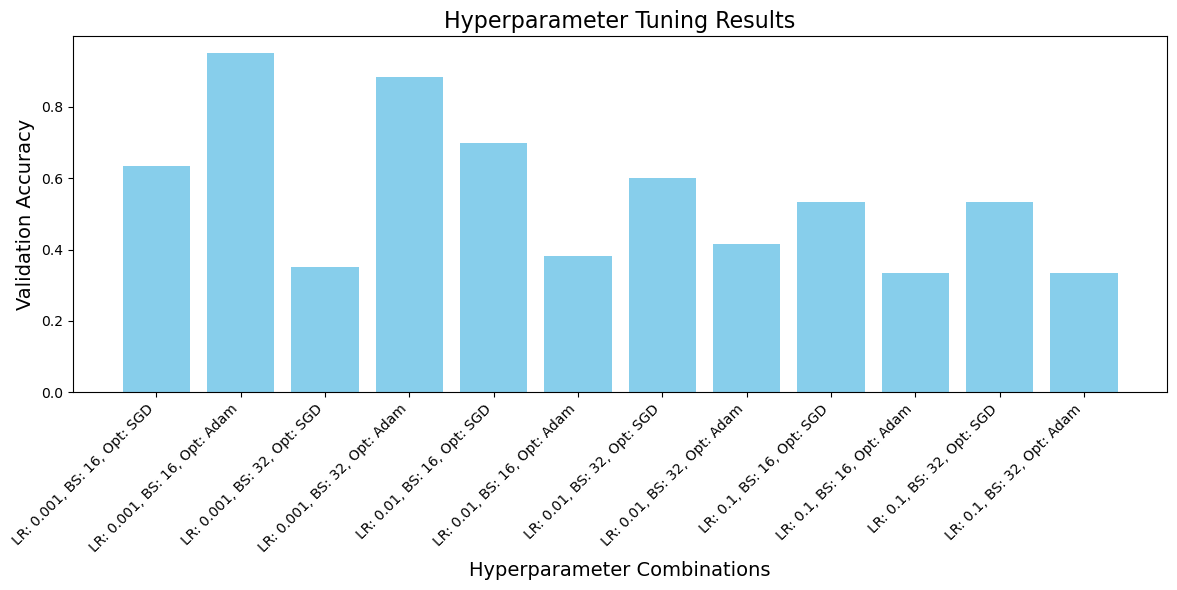

In [65]:
""" 
Visualizing the hyparparameter tunning results.
"""
print("Best Hyperparameters:")
print(best_hyperparams)
print(f"Best Validation Accuracy: {best_validation_accuracy:.4f}")

# Plotting results
hyperparameter_labels = [
    f"LR: {r[0]}, BS: {r[1]}, Opt: {r[2]}" for r in results]
validation_accuracies = [r[3] for r in results]

plt.figure(figsize=(12, 6))
plt.bar(hyperparameter_labels, validation_accuracies, color='skyblue')
plt.xlabel('Hyperparameter Combinations', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.title('Hyperparameter Tuning Results', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./plots/hyperparameter_tuning_results.png')
plt.show()